In [1]:
using Pkg
Pkg.activate("../.")

In [2]:
using Tullio, KernelAbstractions, CUDAKernels 

In [3]:
using Revise, DeconvOptim, Napari, Images, FourierTools, Napari, FFTW, TestImages, Noise, CUDA, Zygote, LinearAlgebra
FFTW.set_num_threads(12)

┌ Info: DeconvOptim.jl: CUDA.jl is loaded, so include GPU functionality
└ @ DeconvOptim /home/fxw/julia/DeconvOptim.jl/src/requires.jl:6
┌ Info: napari version
│   version = 0.4.4
└ @ Napari /home/fxw/.julia/packages/Napari/1a3LQ/src/Napari.jl:48
┌ Info: /home/fxw/julia/PythonEnvs/python38/lib/python3.8/site-packages/napari
└ @ Napari /home/fxw/.julia/packages/Napari/1a3LQ/src/Napari.jl:49


In [4]:
CUDA.allowscalar(false)

In [5]:
# download here http://bigwww.epfl.ch/deconvolution/data/microtubules/
img = Float32.(load("data.tif"));
psf = ifftshift(Float32.(load("psf.tif")));

img_c = CuArray(img)
psf_c = CuArray(psf);

┌ Warning: some versions of ImageMagick give spurious low-order bits for 32-bit TIFFs
└ @ ImageMagick /home/fxw/.julia/packages/ImageMagick/b8swT/src/ImageMagick.jl:100


In [6]:
reg = TV(num_dims=3)

#139 (generic function with 1 method)

In [7]:
reg_c = TV_cuda(num_dims=3)

#15 (generic function with 1 method)

In [8]:
loss = Poisson()

poisson_aux (generic function with 2 methods)

In [13]:
@time res_lr = richardson_lucy_iterative(1f-5 .+ img, psf, iterations=120, λ=0.002f0, regularizer=nothing);

 14.745875 seconds (99.06 k allocations: 519.973 MiB, 0.12% gc time)


In [14]:
GC.gc(true)
CUDA.@time res_lr_c = richardson_lucy_iterative(1f-5 .+ img_c, psf_c, iterations=120, λ=0.002f0, regularizer=nothing);

  1.259250 seconds (13.56 k CPU allocations: 615.188 KiB) (496 GPU allocations: 31.121 GiB, 0.07% gc time of which 79.31% spent allocating)


In [19]:
GC.gc(true)
@time res, o = deconvolution(img, psf, iterations=15, regularizer=reg, λ=0.001f0);

 18.855953 seconds (32.98 k allocations: 11.073 GiB, 24.86% gc time)


In [25]:
GC.gc(true)
@time res, o = deconvolution(img, psf, iterations=15, regularizer=nothing, λ=0.001f0);

 13.958927 seconds (1.05 M allocations: 9.135 GiB, 11.96% gc time, 2.14% compilation time)


In [22]:
GC.gc(true)
CUDA.@time res_c, o = deconvolution(img_c, psf_c, iterations=15, regularizer=reg_c, λ=0.001f0);

  1.552005 seconds (1.67 M CPU allocations: 29.456 MiB, 2.87% gc time) (1.35 k GPU allocations: 50.340 GiB, 28.55% gc time of which 89.41% spent allocating)


In [24]:
GC.gc(true)
CUDA.@time res_c, o = deconvolution(img_c, psf_c, iterations=15, regularizer=nothing, λ=0.001f0);

  0.860296 seconds (1.14 M CPU allocations: 19.313 MiB, 1.36% gc time) (691 GPU allocations: 14.598 GiB, 6.10% gc time of which 75.35% spent allocating)


In [19]:
v = @view_image img
@add_image v Array(res_c)
#@add_image v res
@add_image v res_lr

PyObject <Image layer 'res_lr' at 0x7f3f7c976b50>

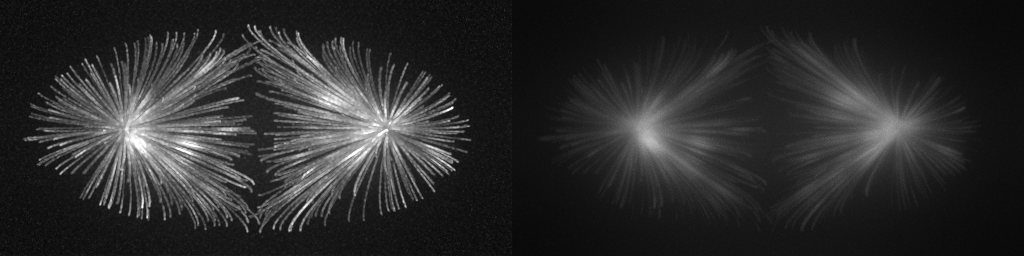

In [18]:
[Gray.(maximum(Array(res_c), dims=3)[:, :, 1] .* 50) Gray.(maximum(img, dims=3)[:, :, 1].* 50)]